<a href="https://colab.research.google.com/github/SuperVerkaufer/Lookalikes/blob/main/Lookalike_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#build a lookalike model using ad click data from Kaggle. Purpose is to train data of clickers and then identify audiences from new dataset likely to click

In [2]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install surprise
import surprise
from surprise import Reader, Dataset
import warnings; warnings.simplefilter('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505174 sha256=1b42f3a5cacdb32a21a80b7aa7f7289ca048f3a2c21f5506643a869e89eec517
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
#UPLOAD DATASETS DOWNLOADED FROM KAGGLE STORED ON desktop (Lookalike FOLDER) to Google Colab
reader = Reader()
from google.colab import files
uploaded = files.upload()

Saving ad_click_dataset.csv to ad_click_dataset.csv


In [4]:
#Read in the dataframe
click = pd.read_csv('ad_click_dataset.csv')
#ad= pd.read_csv('Advertising.csv')
#dig= pd.read_csv('digital_marketing_campaign_dataset.csv')

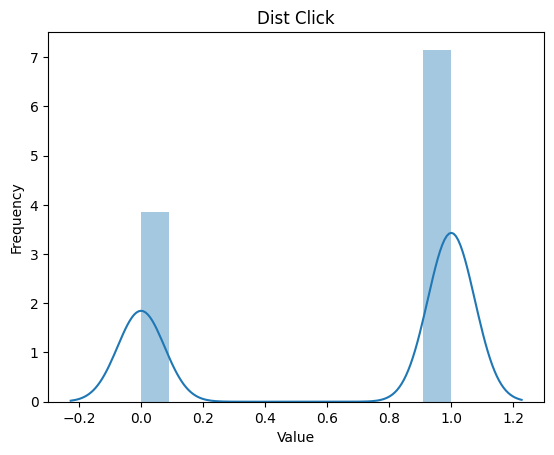

,count
click,
1,6500
0,3500


In [5]:
#Distribution of outcome variable
# Plot the distribution - decide on dataset - need adequate 0s in outcome variable (Can't be all clickers)

sns.distplot(click['click'])
plt.title('Dist Click')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
click['click'].value_counts()

In [6]:
#Explore head
click.head(7)

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
5,5942,User5942,NaN,Non-Binary,NaN,Bottom,Social Media,Evening,1
6,7808,User7808,26.0,Female,Desktop,Top,NaN,NaN,1


In [7]:
#Feature stats & data type
click.describe()
click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


<Figure size 800x600 with 0 Axes>

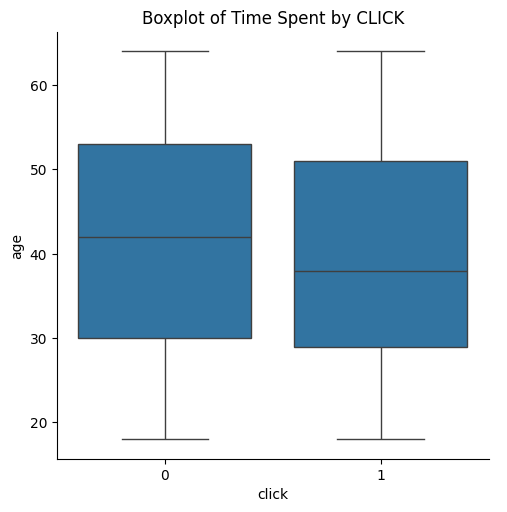

In [8]:
#Profile by clickers, clikers are younger

plt.figure(figsize=(8,6))
sns.catplot(x="click", y="age", kind="box", data=click)
plt.title("Boxplot of Time Spent by CLICK")
plt.show()

<Figure size 800x600 with 0 Axes>

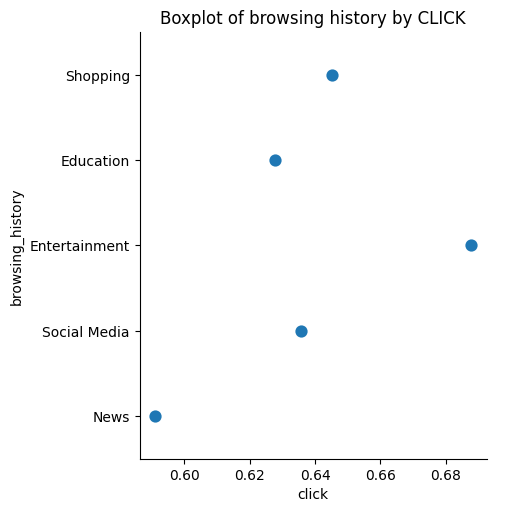

In [9]:
#Profile by clickers, by browsing history. Entertainment history is key predictor

plt.figure(figsize=(8,6))
#sns.catplot(x="click", y="browsing_history", kind="point", data=click)
sns.catplot(x="click", y="browsing_history", kind="point", data=click, dodge=False, join=False, ci=None)
plt.title("Boxplot of browsing history by CLICK")
plt.show()

In [10]:
#Profile by clickers, browsing history
crosstab = pd.crosstab(click['click'], click['browsing_history'], normalize='index')
crosstab_percent = crosstab * 100
# Display the cross-tabulation
print(crosstab_percent)

browsing_history  Education  Entertainment       News   Shopping  Social Media
click                                                                         
0                 20.350691      19.500531  21.200850  18.544102     20.403826
1                 19.364508      24.220624  17.296163  19.034772     20.083933


In [11]:
#Profile by clickers, device type
crosstab = pd.crosstab(click['click'], click['device_type'], normalize='index')
crosstab_percent = crosstab * 100
# Display the cross-tabulation
print(crosstab_percent)

device_type    Desktop     Mobile     Tablet
click                                       
0            32.918149  34.555160  32.526690
1            35.240848  32.331407  32.427746


In [12]:
#Profile by clickers, ad position
crosstab = pd.crosstab(click['click'], click['ad_position'], normalize='index')
crosstab_percent = crosstab * 100
# Display the cross-tabulation
print(crosstab_percent)

ad_position     Bottom       Side        Top
click                                       
0            31.667865  34.255931  34.076204
1            37.102338  31.295516  31.602146


In [13]:
#Profile by clickers, time_of_day
crosstab = pd.crosstab(click["click"], click["time_of_day"], normalize="index")
crosstab_percent = crosstab * 100
# Display the cross-tabulation
print(crosstab_percent)

time_of_day  Afternoon    Evening    Morning      Night
click                                                  
0            22.772989  26.041667  25.574713  25.610632
1            26.495399  23.638804  27.108896  22.756902


In [14]:
#Impute age
from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
from sklearn.impute import IterativeImputer

# Create an IterativeImputer object
imputer = IterativeImputer(max_iter=10, random_state=0)  # Adjust parameters as needed

# Fit and transform the imputer on your data
click_imputed = imputer.fit_transform(click[['age']])  # Select numerical columns

# Update the original DataFrame with imputed values
click[['age']] = click_imputed

In [15]:
#train test split. Treat TEST data as new dataset (Note this is not advisable).
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data into training and testing sets. Assume TestSet is NEW data to find lookalikes, i.e. those likely to click
#X_train, X_testNEW, y_train, y_testNEW = train_test_split(click.drop('click', axis=1), click['click'], test_size=0.3, random_state=42)
#X_train, X_testNEW, y_train, y_testNEW = train_test_split(click[['age','device_type','ad_position','browsing_history','time_of_day']], click['click'], test_size=0.3, random_state=42)

# Split data into training and testing sets, keeping track of customer IDs
X_train, X_testNEW, y_train, y_testNEW, customer_id_train, customer_id_test = train_test_split(
    click[['age','device_type','ad_position','browsing_history','time_of_day']], click['click'], click['id'], test_size=0.3, random_state=42)

In [16]:
# Convert categorical features to numerical using one-hot encoding
X_train = pd.get_dummies(X_train, columns=['device_type', 'ad_position', 'browsing_history', 'time_of_day'])
X_testNEW = pd.get_dummies(X_testNEW, columns=['device_type', 'ad_position', 'browsing_history', 'time_of_day'])
# Align columns between training and testing sets
X_train, X_testNEW = X_train.align(X_testNEW, join='left', axis=1, fill_value=0)

In [17]:
# Train random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Evaluate model performance
y_pred = rfc.predict(X_testNEW)
print("Accuracy:", accuracy_score(y_testNEW, y_pred))
print("Classification Report:")
print(classification_report(y_testNEW, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_testNEW, y_pred))

Accuracy: 0.698
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.41      0.49      1055
           1       0.73      0.85      0.79      1945

    accuracy                           0.70      3000
   macro avg       0.67      0.63      0.64      3000
weighted avg       0.68      0.70      0.68      3000

Confusion Matrix:
[[ 436  619]
 [ 287 1658]]


In [18]:
#How many observations in y_pred?
TESTING_df = pd.DataFrame(y_pred)
TESTING_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3000 non-null   int64
dtypes: int64(1)
memory usage: 23.6 KB


In [19]:
# Create a DataFrame to store predictions along with customer IDs, and compare predicted vs actual
predictions_df = pd.DataFrame({'Customer ID': customer_id_test, 'Predicted Click': y_pred, 'Actual Click': y_testNEW})

# Display the predictions DataFrame
print(predictions_df)

#place predicted click tog with actual click, verify output and lastly try replacing NaN before running model

      Customer ID  Predicted Click  Actual Click
6252         5110                1             1
4684         4086                1             1
1731         6651                1             0
4742         4875                1             0
4521         2077                0             0
...           ...              ...           ...
8014         9550                0             1
1074         1969                1             1
3063         2174                1             1
6487         3746                1             1
4705         2311                1             1

[3000 rows x 3 columns]


In [20]:
# Verify on example above
extracted_row = click.set_index('id')
extracted_row = extracted_row.loc[3746]
extracted_row.head(20)

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
id,,,,,,,,
3746,User3746,40.197363,NaN,NaN,NaN,NaN,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,NaN,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,NaN,Morning,1
3746,User3746,40.197363,Male,NaN,NaN,NaN,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,NaN,Morning,1
3746,User3746,40.197363,Male,NaN,Top,NaN,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,NaN,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,NaN,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,NaN,Morning,1


In [21]:
# Simple Imputer works better than iterative imputer
from sklearn.impute import SimpleImputer

#Create a SimpleImputer object for categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform the imputer on the categorical features
click[['device_type', 'ad_position', 'browsing_history', 'time_of_day']] = cat_imputer.fit_transform(click[['device_type', 'ad_position', 'browsing_history', 'time_of_day']])

In [22]:
#iterative imputer

#from sklearn.preprocessing import LabelEncoder

#categorical_features = ['device_type', 'ad_position', 'browsing_history', 'time_of_day']
#for feature in categorical_features:
#    le = LabelEncoder()
#    click[feature] = le.fit_transform(click[feature])

#imputer = IterativeImputer(max_iter=10, random_state=0)
#imputed_data = imputer.fit_transform(click[categorical_features])

# Update the original DataFrame with imputed values
#click[categorical_features] = imputed_data

#Feature stats & data type
#click.describe()
#click.info()

In [23]:
#Run algo again after performing SIMPLE IMPUTATION and eliminating NaN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data into training and testing sets. Assume TestSet is NEW data to find lookalikes, i.e. those likely to click
#X_train, X_testNEW, y_train, y_testNEW = train_test_split(click.drop('click', axis=1), click['click'], test_size=0.3, random_state=42)
#X_train, X_testNEW, y_train, y_testNEW = train_test_split(click[['age','device_type','ad_position','browsing_history','time_of_day']], click['click'], test_size=0.3, random_state=42)

# Split data into training and testing sets, keeping track of customer IDs
X_train, X_testNEW, y_train, y_testNEW, customer_id_train, customer_id_test = train_test_split(
    click[['age','device_type','ad_position','browsing_history','time_of_day']], click['click'], click['id'], test_size=0.3, random_state=42)

# Convert categorical features to numerical using one-hot encoding
X_train = pd.get_dummies(X_train, columns=['device_type', 'ad_position', 'browsing_history', 'time_of_day'])
X_testNEW = pd.get_dummies(X_testNEW, columns=['device_type', 'ad_position', 'browsing_history', 'time_of_day'])
# Align columns between training and testing sets
X_train, X_testNEW = X_train.align(X_testNEW, join='left', axis=1, fill_value=0)

# Train random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Evaluate model performance
y_pred = rfc.predict(X_testNEW)
print("Accuracy:", accuracy_score(y_testNEW, y_pred))
print("Classification Report:")
print(classification_report(y_testNEW, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_testNEW, y_pred))

#Accuracy improves slightly after SIMPLE IMPUTATION

Accuracy: 0.7083333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.37      0.47      1055
           1       0.72      0.89      0.80      1945

    accuracy                           0.71      3000
   macro avg       0.69      0.63      0.63      3000
weighted avg       0.70      0.71      0.68      3000

Confusion Matrix:
[[ 388  667]
 [ 208 1737]]


In [24]:
# Create a DataFrame to store predictions along with customer IDs, and compare predicted vs actual
# Note the predictions below are based on customer by ocassion, i.e. each customer may have multiple ocassion. We are predicting the outcome based on that customer's ocassion
predictions_df = pd.DataFrame({'Customer ID': customer_id_test, 'Predicted Click': y_pred, 'Actual Click': y_testNEW})
#predictions_df = pd.DataFrame({'Customer ID': customer_id_test, 'Features': X_testNEW, 'Predicted Click': y_pred, 'Actual Click': y_testNEW})
#X_testNEW.info()

X_testNEW_df = pd.DataFrame(X_testNEW['browsing_history_Entertainment']) # If X_testNEW is a NumPy array
predictions_df['browsing_history_Entertainment'] = X_testNEW_df['browsing_history_Entertainment']


# Display the predictions DataFrame
print(predictions_df)

#place predicted click tog with actual click, verify output and lastly try replacing NaN before running model

unique_customer_count = predictions_df['Customer ID'].nunique()
print(f"Number of unique customer IDs: {unique_customer_count}")

      Customer ID  Predicted Click  Actual Click  \
6252         5110                1             1   
4684         4086                1             1   
1731         6651                1             0   
4742         4875                1             0   
4521         2077                1             0   
...           ...              ...           ...   
8014         9550                0             1   
1074         1969                1             1   
3063         2174                1             1   
6487         3746                1             1   
4705         2311                1             1   

      browsing_history_Entertainment  
6252                           False  
4684                            True  
1731                            True  
4742                            True  
4521                            True  
...                              ...  
8014                           False  
1074                            True  
3063                    

In [25]:
#test prediction to see if customer ID conforms to click dataframe. Indeed 3746 likely to have Entertainment as browsing history
predictions_df[predictions_df['Customer ID'] == 3746]

,Customer ID,Predicted Click,Actual Click,browsing_history_Entertainment
4514,3746,1,1,True
4270,3746,1,1,True
5197,3746,1,1,True
6487,3746,1,1,True


In [26]:
# Verify on example above
extracted_row = click.set_index('id')
extracted_row = extracted_row.loc[3746]
extracted_row.head(20)

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
id,,,,,,,,
3746,User3746,40.197363,NaN,Desktop,Bottom,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Bottom,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1
3746,User3746,40.197363,Male,Desktop,Top,Entertainment,Morning,1


In [27]:
# We have to group the predictions by customer ID because there are customer IDs duplicated by Ocassion
grouped_predictions = predictions_df.groupby('Customer ID').agg({
    'Predicted Click': 'sum',
    'Actual Click': 'sum'
})
# Display the grouped predictions DataFrame
print(grouped_predictions)

             Predicted Click  Actual Click
Customer ID                               
7                          4             4
9                          1             0
24                         4             4
28                         1             0
38                         1             0
...                      ...           ...
9967                       4             4
9975                       1             0
9983                       1             0
9990                       6             8
9992                       5             5

[1545 rows x 2 columns]


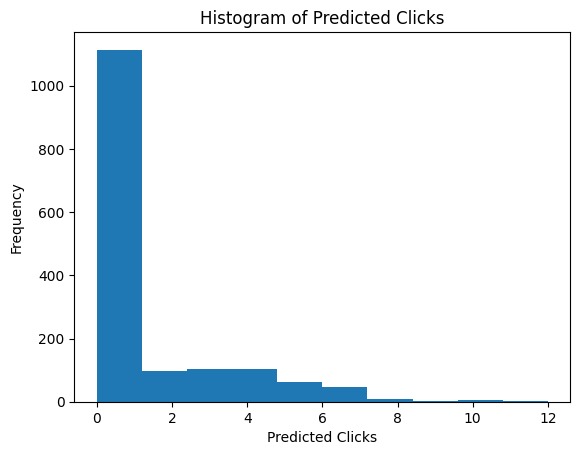

Number of 1 in Predicted Click: 97


In [28]:
# Let's consider how our predictions look like
plt.hist(grouped_predictions['Predicted Click'], bins=10)  # Adjust 'bins' for desired granularity
plt.xlabel('Predicted Clicks')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Clicks')
plt.show()

zero_count = (grouped_predictions['Predicted Click'] == 2).sum()
print(f"Number of 1 in Predicted Click: {zero_count}")

In [29]:
# Let's look at customer IDs predicted to click more than one time
filtered_predictions = grouped_predictions[grouped_predictions['Predicted Click'] > 1]

# Display the filtered predictions DataFrame. These are the lookalikes who are likely to click more frequently
print(filtered_predictions)

             Predicted Click  Actual Click
Customer ID                               
7                          4             4
24                         4             4
58                         6             8
119                        4             6
188                       10            10
...                      ...           ...
9905                       3             3
9966                       2             2
9967                       4             4
9990                       6             8
9992                       5             5

[431 rows x 2 columns]


In [30]:
extracted_row = click.set_index('id')
extracted_row = extracted_row.loc[58]
extracted_row.head(10)

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
id,,,,,,,,
58,User58,40.197363,Female,Mobile,Top,Entertainment,Morning,1
58,User58,36.000000,Female,Mobile,Top,Entertainment,Morning,1
58,User58,40.197363,Female,Desktop,Top,Shopping,Morning,1
58,User58,36.000000,NaN,Mobile,Top,Shopping,Morning,1
58,User58,36.000000,Female,Mobile,Top,Entertainment,Morning,1
58,User58,36.000000,Female,Mobile,Top,Entertainment,Morning,1
58,User58,36.000000,Female,Desktop,Top,Shopping,Morning,1
58,User58,36.000000,Female,Mobile,Top,Shopping,Morning,1
58,User58,36.000000,NaN,Mobile,Bottom,Shopping,Morning,1
